# Main imports and code

In [ ]:
# check which gpu we're using
!nvidia-smi

# Upload files
from google.colab import files
uploaded = files.upload()

Fri Mar  4 10:01:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Saving NLP-20220227T105630Z-001.zip to NLP-20220227T105630Z-001.zip


In [ ]:
#Unzip
#ls NLP
!unzip NLP-20220227T105630Z-001.zip

Archive:  NLP-20220227T105630Z-001.zip
  inflating: NLP/dontpatronizeme_categories.tsv  
  inflating: NLP/dev_semeval_parids-labels.csv  
  inflating: NLP/train_semeval_parids-labels.csv  
  inflating: NLP/dontpatronizeme_pcl.tsv  


In [ ]:
!pip install simpletransformers
!pip install tensorboardx

     |████████████████████████████████| 248 kB 5.1 MB/s 
     |████████████████████████████████| 3.8 MB 61.8 MB/s 
     |████████████████████████████████| 1.2 MB 57.5 MB/s 
     |████████████████████████████████| 1.7 MB 47.3 MB/s 
     |████████████████████████████████| 311 kB 65.5 MB/s 
     |████████████████████████████████| 9.9 MB 49.4 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 6.5 MB 36.0 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
     |████████████████████████████████| 596 kB 62.9 MB/s 
     |████████████████████████████████| 895 kB 45.7 MB/s 
     |████████████████████████████████| 181 kB 43.4 MB/s 
     |████████████████████████████████| 144 kB 55.3 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 212 kB 62.4 MB/s 
     |████████████████████████████████| 1.1 MB 55.8 MB/s 
     |████████████████████████████████| 134 kB 44.2 MB/s 
     |███████████████

     |████████████████████████████████| 125 kB 5.0 MB/s 


In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report

In [ ]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [ ]:
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


2022-03-04 10:48:49.365579: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


# Fetch Don't Patronize Me! data manager module

In [ ]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [ ]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [ ]:
from dont_patronize_me import DontPatronizeMe

In [ ]:
dpm = DontPatronizeMe('./NLP/', './NLP/')

In [ ]:
dpm.load_task1()
dpm.load_task2(return_one_hot=True)

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


# Load paragraph IDs

In [ ]:
trids = pd.read_csv('./NLP/train_semeval_parids-labels.csv')
teids = pd.read_csv('./NLP/dev_semeval_parids-labels.csv')

In [ ]:
trids.head()

,par_id,label
0,4341,"[1, 0, 0, 1, 0, 0, 0]"
1,4136,"[0, 1, 0, 0, 0, 0, 0]"
2,10352,"[1, 0, 0, 0, 0, 1, 0]"
3,8279,"[0, 0, 0, 1, 0, 0, 0]"
4,1164,"[1, 0, 0, 1, 1, 1, 0]"


In [ ]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)



# Rebuild training set (Task 1)

In [ ]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })

  
  

In [ ]:
trdf1 = pd.DataFrame(rows)

# Rebuild test set (Task 1)

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

trdf1['label'].unique()


sum_length ={0:0, 1:0} 
count_labels = {0:0, 1:0}

lengths = {0:[],1:[]}

for (text, label) in zip(trdf1['text'],trdf1['label']):
  tokenized_text = text.split(' ')
  text_length = len(tokenized_text)
  sum_length[label] += text_length
  count_labels[label] +=1
  lengths[label].append(text_length)
  
  if label==0 and count_labels[0]<10: 
    print('\nNon patronizing: ', text)

  if label==1 and count_labels[1]<10: 
    print('\nPatronizing: ', text)
  
print('')
print('Avg length of text with no patronizing text: ', sum_length[0]/count_labels[0])
print('Avg length of text with patronizing text: ', sum_length[1]/count_labels[1])
print('')
print('Number of text samples with no patronizing text: ', count_labels[0])
print('Number of patronizing text samples: ', count_labels[1])


Patronizing:  The scheme saw an estimated 150,000 children from poor families being sent to parts of the British Empire between 1920 and 1974 , by religious orders and charities who said they would lead better lives .

Patronizing:  Durban 's homeless communities reconciliation lunch

Patronizing:  The next immediate problem that cropped up was how to assist the unfortunate couple , as neither of them possessed a birth certificate , a marriage certificate , or even an identity card . The Samurdhi Officer Dhanapala lamented explaining how agonizing it was for him to bear , when he came across the majority of poor families in the village did not possess even an ID to assist them officially .

Patronizing:  Far more important than the implications for the Economy Gods ( is the dollar up or down ? ) last night 's outcome will also mean many , many vulnerable New Zealanders will have a better life over the next three years at least .

Patronizing:  To strengthen child-sensitive social prot

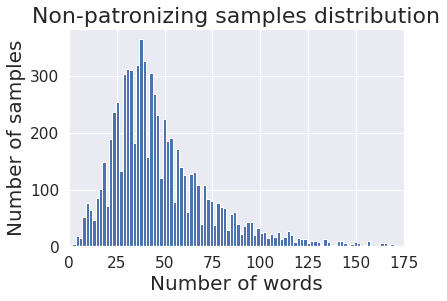

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(lengths[0], bins=100, range=(0,175))
plt.xlim(0,175)
plt.xlabel('Number of words',fontsize=20)
plt.ylabel('Number of samples', fontsize=20)
plt.title('Non-patronizing samples distribution', fontsize=22)
plt.show()
fig.savefig('non-patronizing-hist.png', bbox_inches='tight')

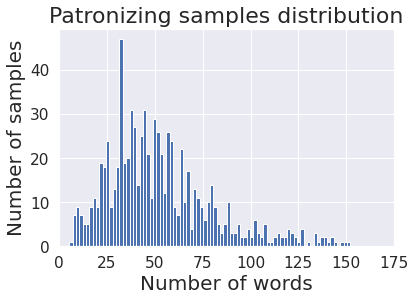

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.hist(lengths[1], bins=100, range=(0,175))
plt.xlim(0,175)
plt.xlabel('Number of words', fontsize=20)
plt.ylabel('Number of samples', fontsize=20)
plt.title('Patronizing samples distribution', fontsize=22)
plt.show()
fig.savefig('patronizing-hist.png',bbox_inches='tight')

In [ ]:
from google.colab import files
files.download('non-patronizing-hist.png') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [ ]:
!ls NLP

dev_semeval_parids-labels.csv	dontpatronizeme_pcl.tsv
dontpatronizeme_categories.tsv	train_semeval_parids-labels.csv


In [ ]:
tedf1 = pd.DataFrame(rows)

# RoBERTa Baseline for Task 1

In [ ]:
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

In [ ]:

training_set1

,par_id,text,label
0,4341,"The scheme saw an estimated 150,000 children f...",1
1,4136,Durban 's homeless communities reconciliation ...,1
2,10352,The next immediate problem that cropped up was...,1
3,8279,Far more important than the implications for t...,1
4,1164,To strengthen child-sensitive social protectio...,1
...,...,...,...
2377,1775,Last but not the least element of culpability ...,0
2378,1776,"Then , taking the art of counter-intuitive non...",0
2379,1777,Kagunga village was reported to lack necessary...,0
2380,1778,"""After her parents high-profile divorce after ...",0


In [ ]:

task1_model_args = ClassificationArgs(num_train_epochs=1, 
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True)
task1_model = ClassificationModel("roberta", 
                                  'roberta-base', 
                                  args = task1_model_args, 
                                  num_labels=2, 
                                  use_cuda=cuda_available)

# train model
task1_model.train_model(training_set1[['text', 'label']])
# run predictions
preds_task1, _ = task1_model.predict(tedf1.text.tolist())

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2382 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

In [ ]:
sum(p.numel() for p in task1_model.model.parameters()) 

## Evaluation for Roberta

In [ ]:
report = classification_report(tedf1.label.tolist(), preds_task1, target_names=["Non-Patronizing","Patronizing"], output_dict= True)

print(report)

{'Non-Patronizing': {'precision': 0.9667063020214031, 'recall': 0.8580474934036939, 'f1-score': 0.9091417388873357, 'support': 1895}, 'Patronizing': {'precision': 0.3470873786407767, 'recall': 0.7185929648241206, 'f1-score': 0.46808510638297873, 'support': 199}, 'accuracy': 0.8447946513849093, 'macro avg': {'precision': 0.6568968403310899, 'recall': 0.7883202291139073, 'f1-score': 0.6886134226351572, 'support': 2094}, 'weighted avg': {'precision': 0.9078217911557179, 'recall': 0.8447946513849093, 'f1-score': 0.8672266147859188, 'support': 2094}}


#Electra for Task 1 

## Defining the Electra model and helper functions

In [ ]:
from transformers import ElectraModel, ElectraConfig, ElectraTokenizer

tokenizer = ElectraTokenizer.from_pretrained("google/electra-base-discriminator")

class PatronizeDataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, input_set):

        self.tokenizer = tokenizer
        self.texts = input_set['text']
        self.labels = input_set['label']
        
    def collate_fn(self, batch):

        texts = []
        labels = []

        for b in batch:
            texts.append(b['text'])
            labels.append(b['label'])

        #The maximum sequence size for BERT is 512 but here the tokenizer truncate sentences longer than 128 tokens.  
        # We also pad shorter sentences to a length of 128 tokens
        encodings = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
        #del encodings['input_ids']
        #del encodings['token_type_ids']
        encodings['label'] =  torch.tensor(labels)
        
        return encodings
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
       
        item = {'text': self.texts[idx],
                'label': self.labels[idx]}
        return item

In [ ]:
train_dataset = PatronizeDataset(tokenizer, training_set1)

In [ ]:
class PatronizingSpeech(ElectraModel):

    def __init__(self, config):
        super().__init__(config)

        print(config)
        # electra Model
        self.electra = ElectraModel(config)
        
        # custom final layer
        self.final_projection = torch.nn.Sequential(torch.nn.Dropout(0.2),
                                                    torch.nn.Linear(config.hidden_size, 2))
        
           
        self.init_weights()

    def forward(self, inputs):
        
        outputs = self.electra(**inputs)[0]
        #print('Outputs shape: ', outputs.size())
        batch_size = outputs.size()[0]
        outputs = torch.mean(outputs,dim=1).reshape(batch_size,-1)
        #print('Outputs shape: ', outputs.size())
        # Logits
        final_logits = self.final_projection(outputs)
        
        return final_logits

In [ ]:
from transformers import Trainer, TrainingArguments

class Trainer_patronizing_speech(Trainer):
    def compute_loss(self, model, inputs):
        labels = {}
        labels['label'] = inputs.pop('label')

        outputs = model(inputs)

        # Binary classification task
        loss_task = torch.nn.CrossEntropyLoss()
        labels = labels['label']
        #print('Outputs shape: ',outputs.view(-1, 2).size())
        #print('Targets shape: ',labels.view(-1).size())
        loss = loss_task(outputs.view(-1, 2), labels.view(-1))
        
        return loss

In [ ]:
def main_patronizing_speech(batch_size=32, learning_rate=0.0001, epochs=3, dataset=train_dataset, model=None):

    #call our custom ELECTRA model and pass as parameter the name of an available pretrained model
    if model==None:
      model = PatronizingSpeech.from_pretrained("google/electra-base-discriminator")
    
    training_args = TrainingArguments(
        output_dir='./experiment/patronizing_speech',
        learning_rate = learning_rate,
        logging_steps= 100,
        per_device_train_batch_size=batch_size,
        num_train_epochs = epochs,
    )
    trainer = Trainer_patronizing_speech(
        model=model,                         
        args=training_args,                 
        train_dataset=dataset,                   
        data_collator=dataset.collate_fn
    )
    trainer.train()

    return model, trainer 



In [ ]:
model, trainer = main_patronizing_speech(batch_size=bs, learning_rate=lr, epochs=1)
sum(p.numel() for p in model.parameters()) 

NameError: ignored

##Evaluation Code for Electra

In [ ]:

def predict_patronizing_speech(input, tokenizer, model): 
  model.eval()
  encodings = tokenizer(input, return_tensors='pt', padding=True, truncation=True, max_length=128)
  
  output = model(encodings)
  preds = torch.max(output, 1)

  return {'prediction':preds[1], 'confidence':preds[0]}

def evaluate(model, tokenizer, data_loader, return_prediction=False):

  total_count = 0
  correct_count = 0 

  preds = []
  tot_labels = []
  tot_text = []
  with torch.no_grad():
    for data in tqdm(data_loader): 

      labels = {}
      labels = data['label']
      text = data['text']

      pred = predict_patronizing_speech(text, tokenizer, model)

      preds.append(pred['prediction'].tolist())
      tot_labels.append(labels.tolist())

      if return_prediction:
        tot_text.append(text)
      
  prediction= (tot_labels, preds, tot_text)
  if return_prediction:
    return prediction

  # with the saved predictions and labels we can compute accuracy, precision, recall and f1-score
  report = classification_report(tot_labels, preds, target_names=["Non-Patronizing","Patronizing"], output_dict= True)

  return report 


## Hyperparameter tuning for Electra

In [ ]:
from torch.utils.data import DataLoader

#model_name = './models/electra_patronizing_finetuned/' 
#model = PatronizingSpeech.from_pretrained(model_name)

# we don't batch our test set unless it's too big
test_dataset =  PatronizeDataset(tokenizer, tedf1)
test_loader = DataLoader(test_dataset)


batch_sizes = [16, 32, 64]
learning_rates = [0.00001, 0.00005, 0.0001, 0.0005]
best_performance = 0

for bs in batch_sizes:
  for lr in learning_rates:
    print('Batch Size: ', bs)
    print('Learning rate: ', lr)
    #Train
    model, trainer = main_patronizing_speech(batch_size=bs, learning_rate=lr, epochs=1)
    
    # Save
    batch_lr = str(bs)+'_'+str(lr)
    model_name = f'./models/electra_patronizing_finetuned{batch_lr}/'
    trainer.save_model(model_name)

    #Load
    model = PatronizingSpeech.from_pretrained(model_name)
    
    #Evaluate
    report = evaluate(model, tokenizer, test_loader)
    print(report)



Batch Size:  16
Learning rate:  1e-05
ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing PatronizingSpeech: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing PatronizingSpeech from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing PatronizingSpeech from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of PatronizingSpeech were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['encoder.layer.5.output.LayerNorm.bias', 'encoder.layer.8.attention.outpu

Step,Training Loss


KeyboardInterrupt: ignored

### Visualization of performance with different hyperparameter settings

In [ ]:
# Upload files
from google.colab import files
uploaded = files.upload()

Saving output.py to output.py


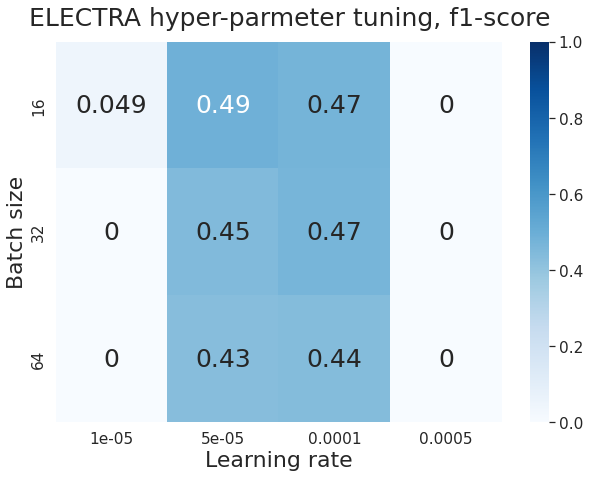

In [ ]:
from output import model, params

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

import numpy as np
f1_map  =np.zeros((3, 4))
bs_keys = {16:0, 32:1, 64:2}
lr_keys = {5e-05: 0, 0.0001:1, 0.0005:2, 1e-05:3}

for i in range(len(model)):
    bs = params[i]['batch_size']
    lr = params[i]['learning_rate']
    f1_score = model[i]['Patronizing']['f1-score']
    
    f1_map[bs_keys[bs]][lr_keys[lr]] = f1_score

f1_map = f1_map[:,[3, 0, 1, 2]]

learning_rates = [1e-05, 5e-05, 0.0001, 0.0005]
batchsizes = [16, 32, 64]

class MidpointNormalize(Normalize):
    """
    Auxiliar function that helps on modifying the scale of colors of a matrix to allow a better visualization
    @Normalize: Normalize object
    """
    
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

plt.rcParams.update({'font.size': 35})
plt.figure(figsize=(10,7))
plt.suptitle('ELECTRA hyper-parmeter tuning, f1-score', y=0.95, x=0.45, size=25)
sns.set(font_scale=1.4)
sns.heatmap(f1_map, cmap='Blues', annot_kws={"size":25}, norm=MidpointNormalize(vmin=0,midpoint=0.5,vmax=1), annot=True , xticklabels=learning_rates, yticklabels=batchsizes)
plt.xlabel("Learning rate", fontsize=22)
plt.ylabel("Batch size", fontsize=22)
plt.savefig('electra_hyperparameter_tuning.png', bbox_inches='tight')
plt.show()

In [ ]:
files.download('electra_hyperparameter_tuning.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Compute accuracy for short and long sentences from the test set.

In [ ]:
dataset = PatronizeDataset(tokenizer, training_set1)
bs = 16
lr = 5e-05

#Train
model, trainer = main_patronizing_speech(batch_size=bs, learning_rate=lr, epochs=1, dataset=dataset)
    
# Save
batch_lr = str(bs)+'_'+str(lr)
model_name = f'./models/electra_patronizing_finetuned{batch_lr}/'
trainer.save_model(model_name)

#Load
model = PatronizingSpeech.from_pretrained(model_name)
    


loading configuration file https://huggingface.co/google/electra-base-discriminator/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/7d1569a4df2372d67341bda716bce4e3edf3e3ffadb97251bc4b6b35d459f624.57c13443a51769ce892714c93bb3ee3952bad66d7d9662d9de382b808377c3f8
Model config ElectraConfig {
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache":

ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing PatronizingSpeech: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing PatronizingSpeech from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing PatronizingSpeech from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of PatronizingSpeech were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['encoder.layer.6.attention.output.dense.bias', 'encoder.layer.8.output.de

Step,Training Loss
100,0.517700




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./models/electra_patronizing_finetuned16_5e-05/
Configuration saved in ./models/electra_patronizing_finetuned16_5e-05/config.json
Model weights saved in ./models/electra_patronizing_finetuned16_5e-05/pytorch_model.bin
loading configuration file ./models/electra_patronizing_finetuned16_5e-05/config.json
Model config ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "PatronizingSpeech"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_act

ElectraConfig {
  "_name_or_path": "./models/electra_patronizing_finetuned16_5e-05/",
  "architectures": [
    "PatronizingSpeech"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



All model checkpoint weights were used when initializing PatronizingSpeech.

All the weights of PatronizingSpeech were initialized from the model checkpoint at ./models/electra_patronizing_finetuned16_5e-05/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PatronizingSpeech for predictions without further training.


In [ ]:
#Evaluate
(labels, preds, tot_text) = evaluate(model, tokenizer, test_loader, return_prediction=True)

  0%|          | 0/2094 [00:00<?, ?it/s]

In [ ]:
short_correct =0
long_correct = 0
short=0
long=0 
for i in range(len(labels)):
  if labels[i]==preds[i] and len(tot_text[i][0].split())>54:
    long_correct +=1
  elif labels[i]==preds[i]:
    short_correct +=1
  
  if len(tot_text[i][0].split())>54:
    long +=1
  else:
    short +=1

print('Short Accuracy: ', short_correct/short)
print('Long Accuracy: ', long_correct/long)

Short Accuracy:  0.8491204330175913
Long Accuracy:  0.801948051948052


In [ ]:
import numpy as np
from scipy import stats

print('Average sentence length of correctly classified: ', np.mean(correct_lengths))
print('Average sentence length of incorrectly classified: ', np.mean(incorrect_lengths))


Average sentence length of correctly classified:  46.66895368782161
Average sentence length of incorrectly classified:  51.176811594202896


## Data Augmentation Experiments with Electra

In [ ]:
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import wordnet, stopwords
import random

"""
Synonym code from : https://maelfabien.github.io/machinelearning/NLP_8/#synonym-replacement-sr
"""

def get_synonyms(word):
    """
    Get synonyms of a word
    """
    synonyms = set()
    
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

stop_words = set(stopwords.words('english'))

def synonym_replacement(words, n):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Evaluation for the finetuned model with the selected hyperparameters using hard data augmentation

In [ ]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  
trdf1 = pd.DataFrame(rows)
  
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

synonym_sentences = [(par_id, synonym_replacement(sent, 5), label) for (par_id, sent,label) in zip(training_set1['par_id'].tolist(), training_set1['text'].tolist(), training_set1['label'].tolist()) if len(sent.split())>54]

synonym_rows = [] # will contain par_id, label and text
for (par_id, sent,label) in synonym_sentences:  
  
  text = sent
  label = label
  synonym_rows.append({
      'par_id':par_id,
      'text':text,
      'label':label
  })

synonym_training_set = pd.DataFrame(synonym_rows)

augmented_training_set = pd.concat([training_set1,  synonym_training_set], ignore_index=True)
  

In [ ]:
augmented_training_set

,par_id,text,label
0,4341,"The scheme saw an estimated 150,000 children f...",1
1,4136,Durban 's homeless communities reconciliation ...,1
2,10352,The next immediate problem that cropped up was...,1
3,8279,Far more important than the implications for t...,1
4,1164,To strengthen child-sensitive social protectio...,1
...,...,...,...
3172,1771,The more I read about Zionism the more I felt ...,0
3173,1772,ISLAMABAD : The federal authorities has announ...,0
3174,1773,"We boast a 100% graduation rate . Blind , deaf...",0
3175,1774,information technology also commits to cater R...,0


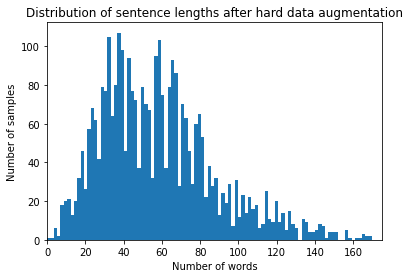

In [ ]:
import matplotlib.pyplot as plt

word_lengths = [len(sent.split()) for sent in augmented_training_set['text'].tolist()]

fig = plt.figure()
plt.hist(word_lengths, bins=100, range=(0,175))
plt.xlim(0,175)
plt.xlabel('Number of words')
plt.ylabel('Number of samples')
plt.title('Distribution of sentence lengths after hard data augmentation')
plt.show()
fig.savefig('hard_augmentation.png')

In [ ]:
augmented_dataset = PatronizeDataset(tokenizer, augmented_training_set)
bs = 16
lr = 5e-05

#Train
model, trainer = main_patronizing_speech(batch_size=bs, learning_rate=lr, epochs=1, dataset=augmented_dataset)
    
# Save
batch_lr = str(bs)+'_'+str(lr)
model_name = f'./models/data_augmented_electra_patronizing_finetuned{batch_lr}/'
trainer.save_model(model_name)

#Load
model = PatronizingSpeech.from_pretrained(model_name)
    
#Evaluate
#report = evaluate(model, tokenizer, test_loader)
#print(report)

loading configuration file https://huggingface.co/google/electra-base-discriminator/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/7d1569a4df2372d67341bda716bce4e3edf3e3ffadb97251bc4b6b35d459f624.57c13443a51769ce892714c93bb3ee3952bad66d7d9662d9de382b808377c3f8
Model config ElectraConfig {
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache":

ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing PatronizingSpeech: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing PatronizingSpeech from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing PatronizingSpeech from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of PatronizingSpeech were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['encoder.layer.5.output.LayerNorm.bias', 'encoder.layer.8.attention.outpu

Step,Training Loss
100,0.523500




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./models/data_augmented_electra_patronizing_finetuned16_5e-05/
Configuration saved in ./models/data_augmented_electra_patronizing_finetuned16_5e-05/config.json
Model weights saved in ./models/data_augmented_electra_patronizing_finetuned16_5e-05/pytorch_model.bin
loading configuration file ./models/data_augmented_electra_patronizing_finetuned16_5e-05/config.json
Model config ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "PatronizingSpeech"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id"

ElectraConfig {
  "_name_or_path": "./models/data_augmented_electra_patronizing_finetuned16_5e-05/",
  "architectures": [
    "PatronizingSpeech"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



All model checkpoint weights were used when initializing PatronizingSpeech.

All the weights of PatronizingSpeech were initialized from the model checkpoint at ./models/data_augmented_electra_patronizing_finetuned16_5e-05/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PatronizingSpeech for predictions without further training.


In [ ]:
#Evaluate
(labels, preds, tot_text) = evaluate(model, tokenizer, test_loader, return_prediction=True)

  0%|          | 0/2094 [00:00<?, ?it/s]

In [ ]:
short_correct =0
long_correct = 0
short=0
long=0 
for i in range(len(labels)):
  if labels[i]==preds[i] and len(tot_text[i][0].split())>54:
    long_correct +=1
  elif labels[i]==preds[i]:
    short_correct +=1
  
  if len(tot_text[i][0].split())>54:
    long +=1
  else:
    short +=1

print('Short Accuracy: ', short_correct/short)
print('Long Accuracy: ', long_correct/long)

Short Accuracy:  0.8761840324763194
Long Accuracy:  0.8392857142857143


### Evaluation for the finetuned model with the selected hyperparameters using soft data augmentation

In [ ]:
from torch.utils.data import DataLoader

test_dataset =  PatronizeDataset(tokenizer, tedf1)
test_loader = DataLoader(test_dataset)

rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  
trdf1 = pd.DataFrame(rows)
  

# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

augment_samp = training_set1.sample(n=800, weights=training_set1['text'].str.len()**3)
synonym_sentences = [(par_id, synonym_replacement(sent, 10), label) for (par_id, sent,label) in zip(augment_samp['par_id'].tolist(), augment_samp['text'].tolist(), augment_samp['label'].tolist())]

synonym_rows = [] # will contain par_id, label and text
for (par_id, sent,label) in synonym_sentences:  
  
  text = sent
  label = label
  synonym_rows.append({
      'par_id':par_id,
      'text':text,
      'label':label
  })

synonym_training_set = pd.DataFrame(synonym_rows)

augmented_training_set = pd.concat([training_set1,  synonym_training_set], ignore_index=True)


In [ ]:
augmented_training_set

,par_id,text,label
0,4341,"The scheme saw an estimated 150,000 children f...",1
1,4136,Durban 's homeless communities reconciliation ...,1
2,10352,The next immediate problem that cropped up was...,1
3,8279,Far more important than the implications for t...,1
4,1164,To strengthen child-sensitive social protectio...,1
...,...,...,...
3177,4113,"""it 's very swage to come across how this is p...",1
3178,1221,How a good deal sensuality has a paraplegic pe...,0
3179,2871,NDP alien personal business critic Paul dewar ...,1
3180,1486,The subtle programs to tardily dispatch the bu...,0


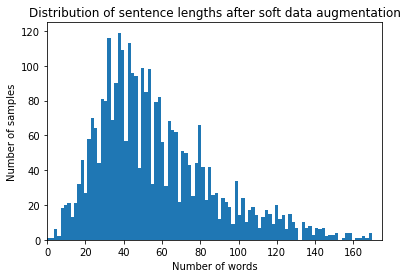

"\nword_lengths = [len(sent.split()) for sent in augment_samp['text'].tolist()]\n\nfig = plt.figure()\nplt.hist(word_lengths, bins=100, range=(0,175))\nplt.xlim(0,175)\nplt.xlabel('Number of words')\nplt.ylabel('Number of samples')\nplt.title('Patronizing samples distribution')\nplt.show()\n"

In [ ]:
import matplotlib.pyplot as plt

word_lengths = [len(sent.split()) for sent in augmented_training_set['text'].tolist()]

fig = plt.figure()
plt.hist(word_lengths, bins=100, range=(0,175))
plt.xlim(0,175)
plt.xlabel('Number of words')
plt.ylabel('Number of samples')
plt.title('Distribution of sentence lengths after soft data augmentation')
plt.show()
fig.savefig('soft_augmentation.png')

"""
word_lengths = [len(sent.split()) for sent in augment_samp['text'].tolist()]

fig = plt.figure()
plt.hist(word_lengths, bins=100, range=(0,175))
plt.xlim(0,175)
plt.xlabel('Number of words')
plt.ylabel('Number of samples')
plt.title('Patronizing samples distribution')
plt.show()
"""


In [ ]:
from google.colab import files
files.download('soft_augmentation.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
augmented_dataset = PatronizeDataset(tokenizer, augmented_training_set)
bs = 16
lr = 5e-05

#Train
model, trainer = main_patronizing_speech(batch_size=bs, learning_rate=lr, epochs=1, dataset=augmented_dataset)
    
# Save
batch_lr = str(bs)+'_'+str(lr)
model_name = f'./models/data_augmented_electra_patronizing_finetuned{batch_lr}/'
trainer.save_model(model_name)

#Load
model = PatronizingSpeech.from_pretrained(model_name)
    
#Evaluate
#report = evaluate(model, tokenizer, test_loader)
#print(report)

loading configuration file https://huggingface.co/google/electra-base-discriminator/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/7d1569a4df2372d67341bda716bce4e3edf3e3ffadb97251bc4b6b35d459f624.57c13443a51769ce892714c93bb3ee3952bad66d7d9662d9de382b808377c3f8
Model config ElectraConfig {
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache":

ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing PatronizingSpeech: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing PatronizingSpeech from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing PatronizingSpeech from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of PatronizingSpeech were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['encoder.layer.5.output.LayerNorm.bias', 'encoder.layer.8.attention.outpu

Step,Training Loss
100,0.532500




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./models/data_augmented_electra_patronizing_finetuned16_5e-05/
Configuration saved in ./models/data_augmented_electra_patronizing_finetuned16_5e-05/config.json
Model weights saved in ./models/data_augmented_electra_patronizing_finetuned16_5e-05/pytorch_model.bin
loading configuration file ./models/data_augmented_electra_patronizing_finetuned16_5e-05/config.json
Model config ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "PatronizingSpeech"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id"

ElectraConfig {
  "_name_or_path": "./models/data_augmented_electra_patronizing_finetuned16_5e-05/",
  "architectures": [
    "PatronizingSpeech"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



All model checkpoint weights were used when initializing PatronizingSpeech.

All the weights of PatronizingSpeech were initialized from the model checkpoint at ./models/data_augmented_electra_patronizing_finetuned16_5e-05/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PatronizingSpeech for predictions without further training.


In [ ]:
#Evaluate
(labels, preds, tot_text) = evaluate(model, tokenizer, test_loader, return_prediction=True)

  0%|          | 0/2094 [00:00<?, ?it/s]

In [ ]:
short_correct =0
long_correct = 0
short=0
long=0 
for i in range(len(labels)):
  if labels[i]==preds[i] and len(tot_text[i][0].split())>54:
    long_correct +=1
  elif labels[i]==preds[i]:
    short_correct +=1
  
  if len(tot_text[i][0].split())>54:
    long +=1
  else:
    short +=1

print('Short Accuracy: ', short_correct/short)
print('Long Accuracy: ', long_correct/long)

Short Accuracy:  0.8775372124492558
Long Accuracy:  0.8262987012987013


# Pre-processing experiments (stop word removal)


In [ ]:
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import wordnet, stopwords
import random

stop_words = set(stopwords.words('english'))

rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  
trdf1 = pd.DataFrame(rows)
  
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

processed_set = [(par_id, ' '.join([word for word in sent if word not in stop_words]), label) for (par_id, sent,label) in zip(training_set1['par_id'].tolist(), training_set1['text'].tolist(), training_set1['label'].tolist())]

processed_rows = [] # will contain par_id, label and text
for (par_id, sent,label) in processed_set:  
  
  text = sent
  label = label
  processed_rows.append({
      'par_id':par_id,
      'text':text,
      'label':label
  })

processed_training_set = pd.DataFrame(processed_rows)
  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
processed_dataset = PatronizeDataset(tokenizer, processed_training_set)
bs = 16
lr = 5e-05

#Train
model, trainer = main_patronizing_speech(batch_size=bs, learning_rate=lr, epochs=1, dataset=processed_dataset)
    
# Save
batch_lr = str(bs)+'_'+str(lr)
model_name = f'./models/stop_processed_electra_patronizing_finetuned{batch_lr}/'
trainer.save_model(model_name)

#Load
model = PatronizingSpeech.from_pretrained(model_name)
    
#Evaluate
report = evaluate(model, tokenizer, test_loader)
print(report)

ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing PatronizingSpeech: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing PatronizingSpeech from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing PatronizingSpeech from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of PatronizingSpeech were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['encoder.layer.4.attention.output.dense.bias', 'encoder.layer.11.attentio

Step,Training Loss
100,0.653200




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./models/stop_processed_electra_patronizing_finetuned16_5e-05/
Configuration saved in ./models/stop_processed_electra_patronizing_finetuned16_5e-05/config.json
Model weights saved in ./models/stop_processed_electra_patronizing_finetuned16_5e-05/pytorch_model.bin
loading configuration file ./models/stop_processed_electra_patronizing_finetuned16_5e-05/config.json
Model config ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "PatronizingSpeech"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id"

ElectraConfig {
  "_name_or_path": "./models/stop_processed_electra_patronizing_finetuned16_5e-05/",
  "architectures": [
    "PatronizingSpeech"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



All model checkpoint weights were used when initializing PatronizingSpeech.

All the weights of PatronizingSpeech were initialized from the model checkpoint at ./models/stop_processed_electra_patronizing_finetuned16_5e-05/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PatronizingSpeech for predictions without further training.


NameError: ignored

In [ ]:
from torch.utils.data import DataLoader

test_dataset =  PatronizeDataset(tokenizer, tedf1)
test_loader = DataLoader(test_dataset)
#Evaluate
report = evaluate(model, tokenizer, test_loader)
print(report)

  0%|          | 0/2094 [00:00<?, ?it/s]

{'Non-Patronizing': {'precision': 0.9049665711556829, 'recall': 1.0, 'f1-score': 0.9501128102281273, 'support': 1895}, 'Patronizing': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 199}, 'accuracy': 0.9049665711556829, 'macro avg': {'precision': 0.45248328557784145, 'recall': 0.5, 'f1-score': 0.47505640511406366, 'support': 2094}, 'weighted avg': {'precision': 0.8189644949092737, 'recall': 0.9049665711556829, 'f1-score': 0.8598203320832384, 'support': 2094}}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Experiments with model structure

In [ ]:
a = torch.tensor([1,2,3])
torch.max(a)

tensor(3)

## Min-mean-max averaging

In [ ]:
class PatronizingSpeech(ElectraModel):

    def __init__(self, config):
        super().__init__(config)

        print(config)
        # electra Model
        self.electra = ElectraModel(config)
        
        # custom final layer
        self.final_projection = torch.nn.Sequential(torch.nn.Dropout(0.2),
                                                    torch.nn.Linear(config.hidden_size*3, 2))
        
           
        self.init_weights()

    def forward(self, inputs):
        
        outputs = self.electra(**inputs)[0]
        #print('Outputs shape: ', outputs.size())
        batch_size = outputs.size()[0]
        outputs_max = torch.max(outputs,dim=1)[0].reshape(batch_size,-1)
        outputs_mean = torch.mean(outputs,dim=1).reshape(batch_size,-1)
        outputs_min = torch.min(outputs,dim=1)[0].reshape(batch_size,-1)

        outputs = torch.concat([outputs_max, outputs_mean, outputs_min], dim=1)
        #print('Outputs shape: ', outputs.size())
        # Logits
        final_logits = self.final_projection(outputs)
        
        return final_logits

In [ ]:
processed_dataset = PatronizeDataset(tokenizer, training_set1)
bs = 16
lr = 5e-05

#Train
model, trainer = main_patronizing_speech(batch_size=bs, learning_rate=lr, epochs=1, dataset=processed_dataset)
    
# Save
batch_lr = str(bs)+'_'+str(lr)
model_name = f'./models/min_mean_max_electra_patronizing_finetuned{batch_lr}/'
trainer.save_model(model_name)

#Load
model = PatronizingSpeech.from_pretrained(model_name)
    
#Evaluate
report = evaluate(model, tokenizer, test_loader)
print(report)

loading configuration file https://huggingface.co/google/electra-base-discriminator/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/7d1569a4df2372d67341bda716bce4e3edf3e3ffadb97251bc4b6b35d459f624.57c13443a51769ce892714c93bb3ee3952bad66d7d9662d9de382b808377c3f8
Model config ElectraConfig {
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache":

ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing PatronizingSpeech: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing PatronizingSpeech from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing PatronizingSpeech from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of PatronizingSpeech were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['encoder.layer.10.attention.self.query.weight', 'encoder.layer.9.output.d

Step,Training Loss
100,0.664700




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./models/min_mean_max_electra_patronizing_finetuned16_5e-05/
Configuration saved in ./models/min_mean_max_electra_patronizing_finetuned16_5e-05/config.json
Model weights saved in ./models/min_mean_max_electra_patronizing_finetuned16_5e-05/pytorch_model.bin
loading configuration file ./models/min_mean_max_electra_patronizing_finetuned16_5e-05/config.json
Model config ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "PatronizingSpeech"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "

ElectraConfig {
  "_name_or_path": "./models/min_mean_max_electra_patronizing_finetuned16_5e-05/",
  "architectures": [
    "PatronizingSpeech"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



All model checkpoint weights were used when initializing PatronizingSpeech.

All the weights of PatronizingSpeech were initialized from the model checkpoint at ./models/min_mean_max_electra_patronizing_finetuned16_5e-05/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PatronizingSpeech for predictions without further training.


  0%|          | 0/2094 [00:00<?, ?it/s]

{'Non-Patronizing': {'precision': 0.9049665711556829, 'recall': 1.0, 'f1-score': 0.9501128102281273, 'support': 1895}, 'Patronizing': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 199}, 'accuracy': 0.9049665711556829, 'macro avg': {'precision': 0.45248328557784145, 'recall': 0.5, 'f1-score': 0.47505640511406366, 'support': 2094}, 'weighted avg': {'precision': 0.8189644949092737, 'recall': 0.9049665711556829, 'f1-score': 0.8598203320832384, 'support': 2094}}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from torch.utils.data import DataLoader

test_dataset =  PatronizeDataset(tokenizer, tedf1)
test_loader = DataLoader(test_dataset)
#Evaluate
report = evaluate(model, tokenizer, test_loader)
print(report)

  0%|          | 0/2094 [00:00<?, ?it/s]

{'Non-Patronizing': {'precision': 0.9049665711556829, 'recall': 1.0, 'f1-score': 0.9501128102281273, 'support': 1895}, 'Patronizing': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 199}, 'accuracy': 0.9049665711556829, 'macro avg': {'precision': 0.45248328557784145, 'recall': 0.5, 'f1-score': 0.47505640511406366, 'support': 2094}, 'weighted avg': {'precision': 0.8189644949092737, 'recall': 0.9049665711556829, 'f1-score': 0.8598203320832384, 'support': 2094}}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Training the final model for more epochs

In [ ]:
from torch.utils.data import DataLoader

#model_name = './models/electra_patronizing_finetuned/' 
#model = PatronizingSpeech.from_pretrained(model_name)

# we don't batch our test set unless it's too big
test_dataset =  PatronizeDataset(tokenizer, tedf1)
test_loader = DataLoader(test_dataset)

rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  
trdf1 = pd.DataFrame(rows)
  
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

synonym_sentences = [(par_id, synonym_replacement(sent, 10), label) for (par_id, sent,label) in zip(training_set1['par_id'].tolist(), training_set1['text'].tolist(), training_set1['label'].tolist()) if len(sent.split())>54]

synonym_rows = [] # will contain par_id, label and text
for (par_id, sent,label) in synonym_sentences:  
  
  text = sent
  label = label
  synonym_rows.append({
      'par_id':par_id,
      'text':text,
      'label':label
  })

synonym_training_set = pd.DataFrame(synonym_rows)

augmented_training_set = pd.concat([training_set1,  synonym_training_set], ignore_index=True)



  

In [ ]:
augmented_dataset = PatronizeDataset(tokenizer, augmented_training_set)
bs = 16
lr = 5e-05

f1_scores = []
num_epochs = 100
model=None
for i in range(num_epochs):
  #Train
  model, trainer = main_patronizing_speech(batch_size=bs, learning_rate=lr, epochs=1, dataset=augmented_dataset, model=model)
    
  # Save
  batch_lr = str(bs)+'_'+str(lr)
  model_name = f'./models/final_data_augmented_electra_patronizing_finetuned{batch_lr}/'
  trainer.save_model(model_name)

  #Load
  model = PatronizingSpeech.from_pretrained(model_name)
    
  #Evaluate
  report = evaluate(model, tokenizer, test_loader)['Patronizing']['f1-score']
  print(report)
  f1_scores.append(report)

  print('f1_scores: ', f1_scores)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing PatronizingSpeech: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing PatronizingSpeech from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing PatronizingSpeech from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of PatronizingSpeech were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['encoder.layer.4.attention.self.query.bias', 'encoder.layer.1.attention.s

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

## Early stopping

In [ ]:
augmented_dataset = PatronizeDataset(tokenizer, augmented_training_set)
bs = 16
lr = 5e-05

f1_scores = []
num_epochs = 3
model=None
for i in range(num_epochs):
  #Train
  model, trainer = main_patronizing_speech(batch_size=bs, learning_rate=lr, epochs=1, dataset=augmented_dataset, model=model)
    
  # Save
  batch_lr = str(bs)+'_'+str(lr)
  model_name = f'./models/final_data_augmented_electra_patronizing_finetuned{batch_lr}/'
  trainer.save_model(model_name)

#Load
model = PatronizingSpeech.from_pretrained(model_name)
    
#Evaluate
#report = evaluate(model, tokenizer, test_loader)['Patronizing']['f1-score']
#print(report)
#f1_scores.append(report)

#print('f1_scores: ', f1_scores)

ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing PatronizingSpeech: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing PatronizingSpeech from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing PatronizingSpeech from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of PatronizingSpeech were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['encoder.layer.9.attention.self.query.weight', 'encoder.layer.5.attention

Step,Training Loss
100,0.515500




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./models/final_data_augmented_electra_patronizing_finetuned16_5e-05/
Configuration saved in ./models/final_data_augmented_electra_patronizing_finetuned16_5e-05/config.json
Model weights saved in ./models/final_data_augmented_electra_patronizing_finetuned16_5e-05/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
**

Step,Training Loss


Step,Training Loss
100,0.298700




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./models/final_data_augmented_electra_patronizing_finetuned16_5e-05/
Configuration saved in ./models/final_data_augmented_electra_patronizing_finetuned16_5e-05/config.json
Model weights saved in ./models/final_data_augmented_electra_patronizing_finetuned16_5e-05/pytorch_model.bin
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 3177
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 199
Automatic Weights & Biases logging enabled, to disable set o

Step,Training Loss
100,0.125000




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./models/final_data_augmented_electra_patronizing_finetuned16_5e-05/
Configuration saved in ./models/final_data_augmented_electra_patronizing_finetuned16_5e-05/config.json
Model weights saved in ./models/final_data_augmented_electra_patronizing_finetuned16_5e-05/pytorch_model.bin
loading configuration file ./models/final_data_augmented_electra_patronizing_finetuned16_5e-05/config.json
Model config ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "PatronizingSpeech"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layer

ElectraConfig {
  "_name_or_path": "./models/final_data_augmented_electra_patronizing_finetuned16_5e-05/",
  "architectures": [
    "PatronizingSpeech"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



All model checkpoint weights were used when initializing PatronizingSpeech.

All the weights of PatronizingSpeech were initialized from the model checkpoint at ./models/final_data_augmented_electra_patronizing_finetuned16_5e-05/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PatronizingSpeech for predictions without further training.


#Evaluate on the final test set

In [ ]:
# Upload files
from google.colab import files
uploaded = files.upload()

Saving task4_test.tsv to task4_test.tsv


In [ ]:
#!mkdir final_test
#!mv task4_test.tsv final_test
#!ls final_test
#!head final_test/task4_test.tsv
with open('final_test/task4_test.tsv','r') as f:
  lines = f.readlines()
  test_text = [{'par_id':-1, 'label':-1, 'text':lines[i].split('\t')[-1]} for i in range(len(lines))]

In [ ]:
final_test = pd.DataFrame(test_text)

In [ ]:
from torch.utils.data import DataLoader

#model_name = './models/electra_patronizing_finetuned/' 
#model = PatronizingSpeech.from_pretrained(model_name)

# we don't batch our test set unless it's too big
test_dataset =  PatronizeDataset(tokenizer, final_test)
test_loader = DataLoader(test_dataset)

In [ ]:
#Evaluate on the final test set

(labels, preds, tot_text) = evaluate(model, tokenizer, test_loader, return_prediction=True)
labels2file(preds, 'task1.txt')

  0%|          | 0/3832 [00:00<?, ?it/s]

In [ ]:
len(preds)

3832

In [ ]:
!cat task1.txt | head -n 10
!zip submission.zip task1.txt

0
0
0
0
0
0
1
0
0
0
updating: task1.txt (deflated 93%)


In [ ]:
from google.colab import files
files.download('submission.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Analysis

In [ ]:
dpm.train_task2_df

,par_id,art_id,text,keyword,country,label
0,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,"[1, 0, 0, 1, 0, 0, 0]"
1,1279,@@7896098,Pope Francis washed and kissed the feet of Mus...,refugee,ng,"[0, 1, 0, 0, 0, 0, 0]"
2,8330,@@17252299,Many refugees do n't want to be resettled anyw...,refugee,ng,"[0, 0, 1, 0, 0, 0, 0]"
3,4063,@@3002894,"""Budding chefs , like """" Fred """" , """" Winston ...",in-need,ie,"[1, 0, 0, 1, 1, 1, 0]"
4,4089,@@25597822,"""In a 90-degree view of his constituency , one...",homeless,pk,"[1, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...
988,873,@@20374243,Citing the fact that these kids who died at Go...,poor-families,sg,"[1, 0, 0, 0, 1, 0, 0]"
989,10070,@@15573661,Fern ? ndez was a well-known philanthropist wh...,disabled,ng,"[1, 0, 0, 0, 0, 0, 0]"
990,6484,@@2559173,"Touched much by their plight , Commanding Offi...",homeless,lk,"[1, 0, 0, 0, 0, 1, 0]"
991,6249,@@1947926,She reiterated her ministry 's commitment to p...,women,gh,"[1, 0, 0, 0, 0, 0, 0]"


In [ ]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  orig_label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].orig_label.values[0]
  
  keyword = dpm.train_task2_df.loc[dpm.train_task2_df.par_id == parid].keyword.values
  country = dpm.train_task2_df.loc[dpm.train_task2_df.par_id == parid].country.values
  
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label,
      'orig_label':orig_label,
      'keyword':keyword,
      'country':country

  })
  

In [ ]:
print(len(preds))

2094


In [ ]:
tedf1 = pd.DataFrame(rows)
from torch.utils.data import DataLoader

# we don't batch our test set unless it's too big
test_dataset =  PatronizeDataset(tokenizer, tedf1)
test_loader = DataLoader(test_dataset)

#Evaluate on the test set

(labels, preds, tot_text) = evaluate(model, tokenizer, test_loader, return_prediction=True)

  0%|          | 0/2094 [00:00<?, ?it/s]

In [ ]:
tedf1 = pd.DataFrame(rows)
from torch.utils.data import DataLoader

# we don't batch our test set unless it's too big
test_dataset =  PatronizeDataset(tokenizer, tedf1)
test_loader = DataLoader(test_dataset)

#Evaluate on the test set

report = evaluate(model, tokenizer, test_loader)

  0%|          | 0/2094 [00:00<?, ?it/s]

In [ ]:
report

{'Non-Patronizing': {'precision': 0.9661412726211325,
  'recall': 0.8733509234828496,
  'f1-score': 0.9174057649667406,
  'support': 1895},
 'Patronizing': {'precision': 0.3700787401574803,
  'recall': 0.7085427135678392,
  'f1-score': 0.4862068965517241,
  'support': 199},
 'accuracy': 0.8576886341929322,
 'macro avg': {'precision': 0.6681100063893064,
  'recall': 0.7909468185253443,
  'f1-score': 0.7018063307592324,
  'support': 2094},
 'weighted avg': {'precision': 0.9094954063554846,
  'recall': 0.8576886341929322,
  'f1-score': 0.8764274579874722,
  'support': 2094}}

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_cl

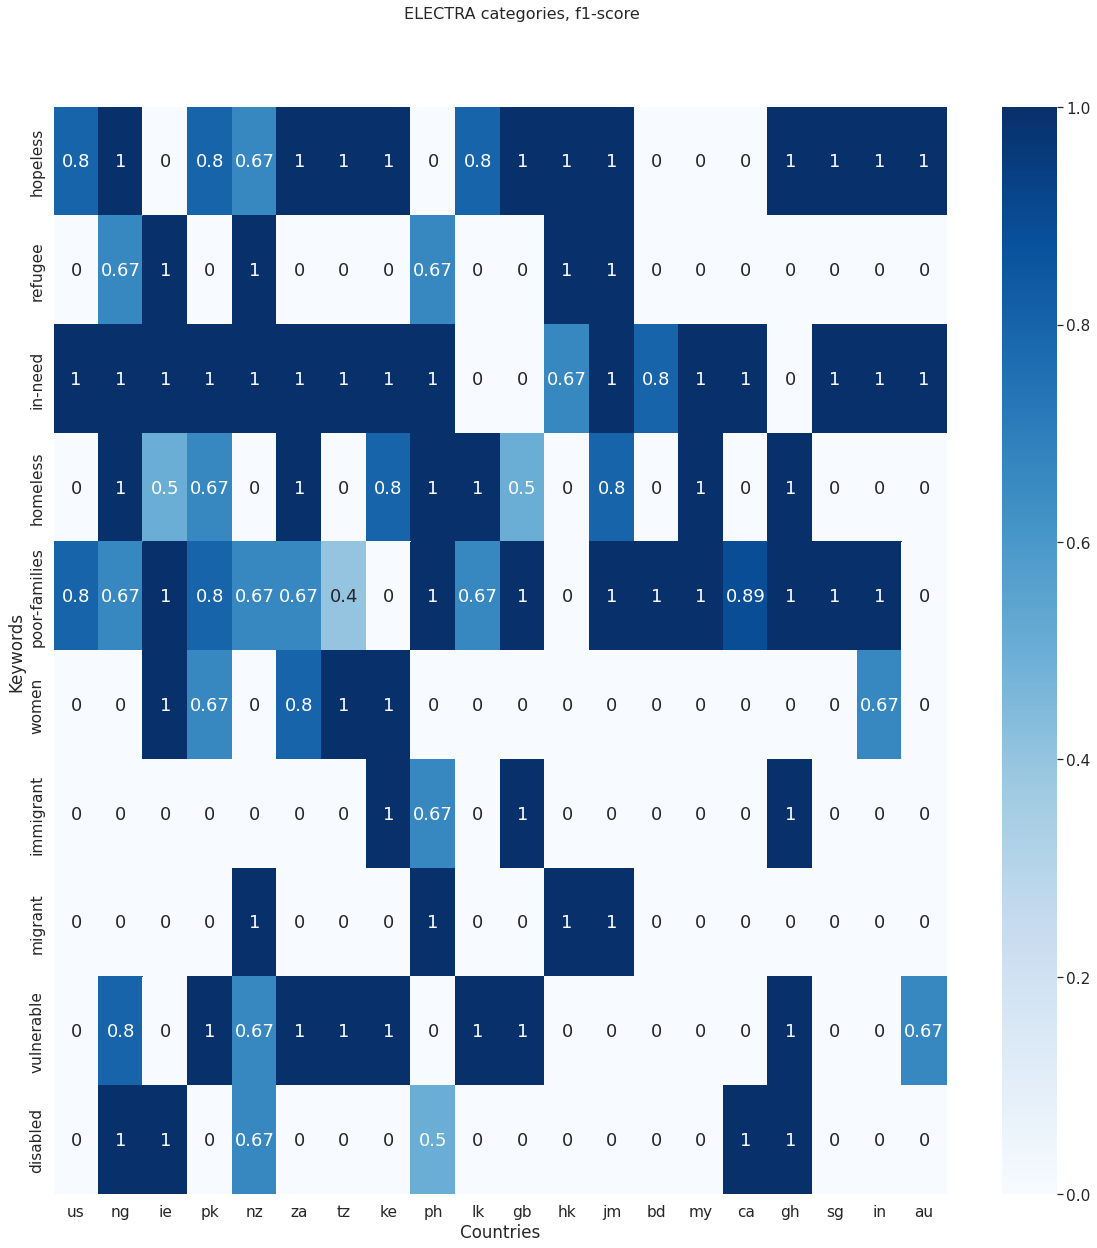

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

from sklearn.metrics import f1_score
total_count=0
import numpy as np
pred_map = {}
labels_map = {}

f1_map  = np.zeros((len(dpm.train_task2_df['keyword'].unique()), len(dpm.train_task2_df['country'].unique())))
counts_map  = np.zeros((len(dpm.train_task2_df['keyword'].unique()), len(dpm.train_task2_df['country'].unique())))
keyword_keys = {keyword:i for (i, keyword) in enumerate(dpm.train_task2_df['keyword'].unique())}
country_keys = {country:i for (i, country) in enumerate(dpm.train_task2_df['country'].unique())}


for keyword in dpm.train_task2_df['keyword'].unique():
  pred_map[keyword] ={}
  labels_map[keyword] ={}
  for country in dpm.train_task2_df['country'].unique():
    pred_map[keyword][country] =[]
    labels_map[keyword][country] = []

for i in range(len(labels)):
    if labels[i][0]!=1:
      # Only consider counts when the ground truth label is patronizing
      continue
    try:
      keyword = rows[i]['keyword'][0]
      country =rows[i]['country'][0]
      pred_map[keyword][country].append(preds[i]) 
      labels_map[keyword][country].append(labels[i])
    except:
      continue

for keyword in dpm.train_task2_df['keyword'].unique():
  for country in dpm.train_task2_df['country'].unique():
    f1 = f1_score(labels_map[keyword][country], pred_map[keyword][country])
    
    f1_map[keyword_keys[keyword]][country_keys[country]] = f1

    counts_map[keyword_keys[keyword]][country_keys[country]] = len(labels_map[keyword][country])
    total_count += len(labels_map[keyword][country])

keywords = dpm.train_task2_df['keyword'].unique()
countries = dpm.train_task2_df['country'].unique()

class MidpointNormalize(Normalize):
    """
    Auxiliar function that helps on modifying the scale of colors of a matrix to allow a better visualization
    @Normalize: Normalize object
    """
    
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(20,20))
plt.suptitle('ELECTRA categories, f1-score', y=0.95, x=0.45, size=16)
sns.set(font_scale=1.4)
sns.heatmap(f1_map, cmap='Blues', annot_kws={"size":18}, norm=MidpointNormalize(vmin=0,midpoint=0.5,vmax=1), annot=True , xticklabels=countries, yticklabels=keywords)
plt.xlabel("Countries")
plt.ylabel("Keywords")
plt.savefig('electra_categories.png', bbox_inches='tight')
plt.show()

In [ ]:
#[f1_map[keyword_keys[k]] for k in keywords][0]
[(k,np.sum(f1_map[keyword_keys[k]])/np.sum([1 for c in counts_map[keyword_keys[k]] if c!=0])) for k in keywords]

[('hopeless', 0.8274509803921568),
 ('refugee', 0.5925925925925926),
 ('in-need', 0.9148148148148147),
 ('homeless', 0.7128205128205127),
 ('poor-families', 0.7660818713450293),
 ('women', 0.7333333333333334),
 ('immigrant', 0.611111111111111),
 ('migrant', 0.8),
 ('vulnerable', 0.7611111111111111),
 ('disabled', 0.5166666666666666)]

In [ ]:
[(c,np.sum(f1_map[:, country_keys[c]])/np.sum([1 for a in counts_map[:, country_keys[c]] if a!=0])) for c in countries]

[('us', 0.52),
 ('ng', 0.8761904761904761),
 ('ie', 0.9166666666666666),
 ('pk', 0.7047619047619048),
 ('nz', 0.7083333333333334),
 ('za', 0.9111111111111111),
 ('tz', 0.7333333333333334),
 ('ke', 0.9666666666666667),
 ('ph', 0.7291666666666666),
 ('lk', 0.8666666666666667),
 ('gb', 0.6428571428571429),
 ('hk', 0.611111111111111),
 ('jm', 0.9666666666666667),
 ('bd', 0.36),
 ('my', 0.75),
 ('ca', 0.7222222222222222),
 ('gh', 0.75),
 ('sg', 0.75),
 ('in', 0.7333333333333333),
 ('au', 0.6666666666666666)]

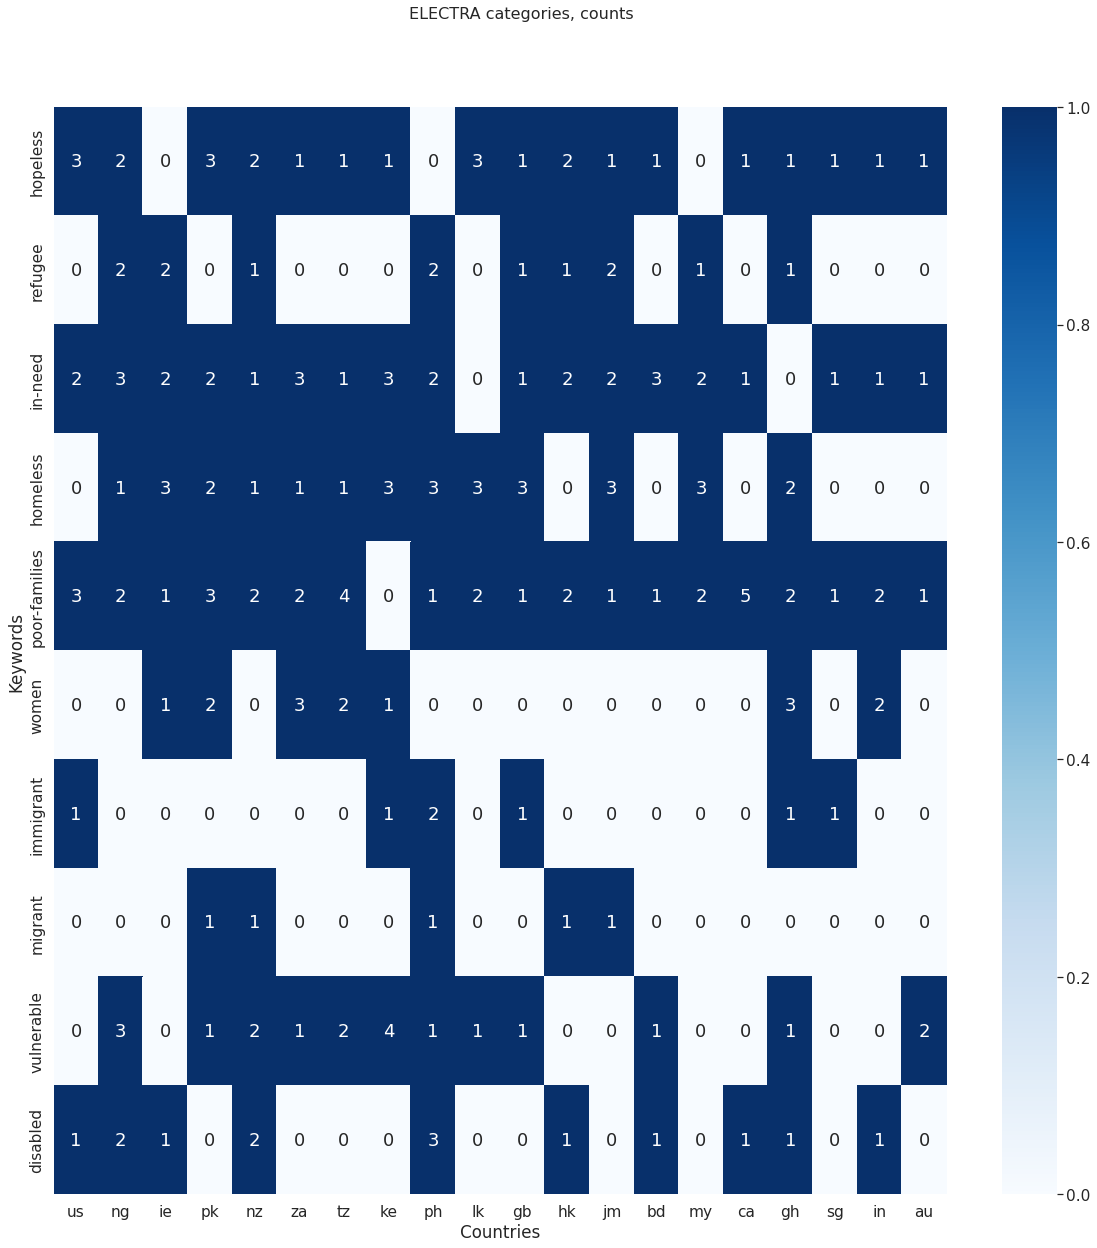

In [ ]:
~plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(20,20))
plt.suptitle('ELECTRA categories, counts', y=0.95, x=0.45, size=16)
sns.set(font_scale=1.4)
sns.heatmap(counts_map, cmap='Blues', annot_kws={"size":18}, norm=MidpointNormalize(vmin=0,midpoint=0.5,vmax=1), annot=True , xticklabels=countries, yticklabels=keywords)
plt.xlabel("Countries")
plt.ylabel("Keywords")
plt.show()

In [ ]:
print(total_count)

199


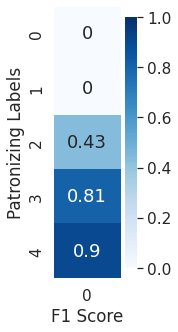

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

from sklearn.metrics import f1_score
total_count=0
import numpy as np
pred_map = {}
labels_map = {}

f1_map  = np.zeros((1,len(dpm.train_task1_df['orig_label'].unique())))
counts_map  = np.zeros((1,len(dpm.train_task1_df['orig_label'].unique())))
orig_label_keys = {ol:i for (i, ol) in enumerate(dpm.train_task1_df['orig_label'].unique())}


for ol in dpm.train_task1_df['orig_label'].unique():
  pred_map[ol] =[]
  labels_map[ol] =[]

for i in range(len(labels)):
    try:
      ol = rows[i]['orig_label'][0]
      pred_map[ol].append(preds[i]) 
      labels_map[ol].append(labels[i])
    except:
      continue

for ol in dpm.train_task1_df['orig_label'].unique():
  f1 = f1_score(labels_map[ol], pred_map[ol])
  
  f1_map[0][orig_label_keys[ol]] = f1

  counts_map[0][orig_label_keys[ol]] = len(labels_map[ol])
  total_count += len(labels_map[ol])

orig_labels = dpm.train_task1_df['orig_label'].unique()

class MidpointNormalize(Normalize):
    """
    Auxiliar function that helps on modifying the scale of colors of a matrix to allow a better visualization
    @Normalize: Normalize object
    """
    
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

f1_map = f1_map.transpose()
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(1.5,5))
#plt.suptitle('ELECTRA patronizing levels, f1-score', y=0.95, x=0.45, size=16)
sns.set(font_scale=1.4)
sns.heatmap(f1_map, cmap='Blues', annot_kws={"size":18}, norm=MidpointNormalize(vmin=0,midpoint=0.5,vmax=1), annot=True , xticklabels=[0], yticklabels=orig_labels)
plt.ylabel("Patronizing Labels")
plt.xlabel("F1 Score")
plt.savefig('electra_levels.png', bbox_inches='tight')
plt.show()

In [ ]:
from google.colab import files
files.download('electra_levels.png') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>